In [1]:
import numpy as np
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy


#### Initial idea: choose a transformation $T$ and a way to measure distance wrt that transformation
For example:
1. I can decide that 2 functions $f_1$, $f_2$ are identical if they are proportional, or if you can obtain $f_2$ graph from $f_1$ by translating $f_1$ on the $y-$axis or the $x-$axis 

Ideally, I'd like to consider the closest affine transformations $Y = AX + b$, but I dont know if there is a way to find the best $A$, $b$ or if it would take any real big matrix inversion if dimension of X is high. For now, I model the case when $f_2(x) = af_1(x) + b$ and find suitable $a, b$ to minimize mean square error

2. Decide how distance between $f_2$ and $T(f_1)$. } is measured. For example:
    1. $\#\{x$ such that $|f_2(x) - T(f_1(x)| > \delta\}$
    2. $\%\{x$ such that $|f_2(x) - T(f_1(x)| > \delta\}$
    3. $\sum_{f_2 - Tf_1 > \delta}{|f_2(x) - Tf_1(x)|}$
    4. Previous one but with any other distance (euclidean eg)
    5. This is not a mathematical distance (assimetry), but same as C. but without abs values? So that a flattened cosine is similar to $y = 0$ (For this option it would suffice to set $\delta = flat\_cos(0)$)
    6. Max difference (norma infinito)
    7. Mean difference



In [2]:
# Various distance definitions 

#A
def npoints_more_than(m1, m2, delta = 0):
    return (np.abs(m1-m2)>delta).sum()
#B
def percentage_more_than(m1, m2, delta = 0):
    return 100*(np.abs(m1-m2)>delta).sum()/len(m1)
#C
def sum_difference(m1, m2, delta = 0):
    return np.abs(m1-m2)[np.where(np.abs(m1-m2) > delta)].sum()
#F delta not needed. Just added to fit the mean_dist method called from below
def max_difference(m1, m2, delta = 0):
    return np.amax(np.abs(m1-m2))
#G delta not needed
def avg_difference(m1,m2, delta = 0):
    return np.abs(m1-m2).sum()/len(m1)
# Error cuadratico
def quad_error(m1,m2, delta=0):
    return np.linalg.norm(m1-m2)
    


In [5]:
# Transformations
from scipy.optimize import curve_fit

#line = lambda x, a, b: a*x + b
def line(x, a, b):
    return a * x + b

#finds best a, b such that gp2 = a*gp1 + b
def line_transform(m1, m2, X):
    popt, pcov = curve_fit(line, m1, m2)
    #print(popt)
    Tm1 = line(m1, popt[0], popt[1])
    return Tm1


'''
* gp1, gp2 are the processes to be predicted over the domain X
* epsilon1 \in [0,1] is the weight that will be given in the final distance to the distance between gp1 and gp2 means
  epsilon2 is the weight thatll be given to the correlation between the means
  1 - epsilon1 - epsilon2 will be the weight given to the distance between their variance
* transformation is a function with respect to which we decide if mean1 and mean2 are similar.
i.e., distance(mean1, mean2) = 0 iff mean2 = transformation(m1). (transformation could be calculated as a curve fit)
* var_dist and mean_dist are functions to define the distance between both mean vectors/ variance vectors
* delta is a number used as an argument in mean_dist to decide when the distance between two values is negligible. 
e.g., mean_dist(m1,m2) = sum(|m1-m2| when |m1-m2|> delta)
'''
def distance(gp1, gp2, X, 
             epsilon1 = 0.45, epsilon2 = 0.45, delta = 0.1, 
             transformation = line_transform, 
             mean_dist = avg_difference, 
             var_dist = np.linalg.norm):
    
    m1, v1 = gp1.predict_noiseless(X, full_cov = True)
    m2, v2 = gp2.predict_noiseless(X, full_cov = True)
    m1= m1.flatten()
    m2 = m2.flatten()
    Tm1 = transformation(m1, m2, X)
    print(m1.shape, m2.shape, X.shape)
    
    d1 = mean_dist(Tm1, m2, delta)
    print("\nDistance between means, ", d1)
    corrmat = np.corrcoef(m1, m2)    
    ro = (corrmat[1][0]).round(5)
    d2 =  1-ro
    print("Correlation between means, ", 1-d2)
    # Escribo delta = 0 xq, asumiendo que las varianzas son valores pequeños, solo tendria sentido
    # escribir delta peque. Puedes probar con otros valores (delta2?) si las varianzas son grandes
    d3 = var_dist(v1-v2)
    print("Distance between cov matrices, ", d3)
    
    return epsilon1*d1 + epsilon2*d2 + (1-epsilon1 - epsilon2)*d3
    #return epsilon1*d1 + (1-epsilon1)*d2
    

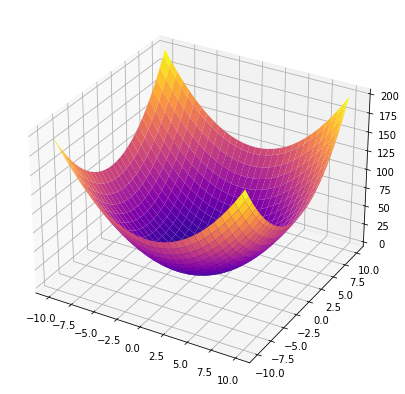

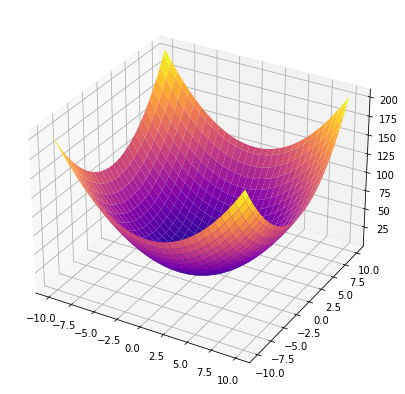

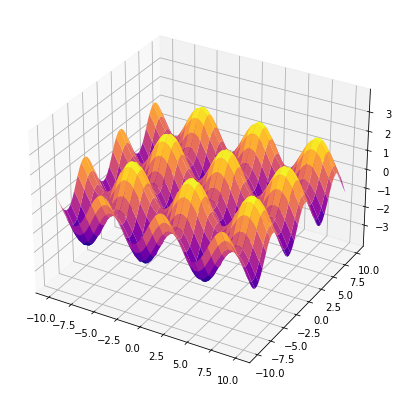

In [6]:
f1 = lambda x, y: x**2 + y**2
f2 = lambda x, y: x**2 + y**2 + 4
f3 = lambda x, y: np.sin(x)+ np.sin(y)

x = np.linspace(-10, 10, 60)
y = np.linspace(-10, 10, 60)

X, Y = np.meshgrid(x, y)
Z1 = f1(X, Y)
Z2 = f2(X, Y)
Z3 = f3(X, Y)

fig = plt.figure(figsize=(18, 7))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z1, cmap='plasma')
ax.set_zlim(np.min(Z1)-2,np.max(Z1)+2)
plt.show()

fig = plt.figure(figsize=(18, 7))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z2, cmap='plasma')
ax.set_zlim(np.min(Z2)-2,np.max(Z2)+2)
plt.show()

fig = plt.figure(figsize=(18, 7))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z3, cmap='plasma')
ax.set_zlim(np.min(Z3)-2,np.max(Z3)+2)
plt.show()



In [7]:
# Para hacer regresión

# Samples
nsamples = 20
x = np.linspace(-10, 10, nsamples)
y = np.linspace(-10, 10, nsamples)

X, Y = np.meshgrid(x, y)
Z1 = f1(X, Y)
Z2 = f2(X, Y)
Z3 = f3(X, Y)

# Puntos a predecir
npredict = 50
xnew = np.linspace(-10, 10, npredict)
ynew = np.linspace(-10, 10, npredict)
Xnew, Ynew = np.meshgrid(xnew, ynew)

# Cambiamos formato de datos para hacer regresion
XY = np.stack((X.flatten(), Y.flatten()), axis = -1)
Z1 = Z1.reshape(Z1.size, 1)
Z2 = Z2.reshape(Z2.size, 1)
Z3 = Z3.reshape(Z3.size, 1)
XYnew = np.stack((Xnew.flatten(), Ynew.flatten()), axis = -1)

# Covariance between training sample points
k = GPy.kern.RBF(2, variance=1., lengthscale=1, name="rbf")
Kxx = k.K(X,X) 

import time
t1 = time.process_time()
gp1 = GPy.models.GPRegression(XY, Z1, k)
t2 = time.process_time()
mean1, Cov1 = gp1.predict_noiseless(XYnew, full_cov=True)
t3 = time.process_time()
print(t2-t1,t3-t2)

t1 = time.process_time()
gp2 = GPy.models.GPRegression(XY, Z2, k)
t2 = time.process_time()
mean2, Cov2 = gp2.predict_noiseless(XYnew, full_cov=True)
t3 = time.process_time()
print(t2-t1,t3-t2)

t1 = time.process_time()
gp3 = GPy.models.GPRegression(XY, Z3, k)
t2 = time.process_time()
mean3, Cov3 = gp3.predict_noiseless(XYnew, full_cov=True)
t3 = time.process_time()
print(t2-t1,t3-t2)


0.7909177190000003 4.115226882
0.15662534600000022 3.8060224199999997
0.1799200230000011 4.016276719999999


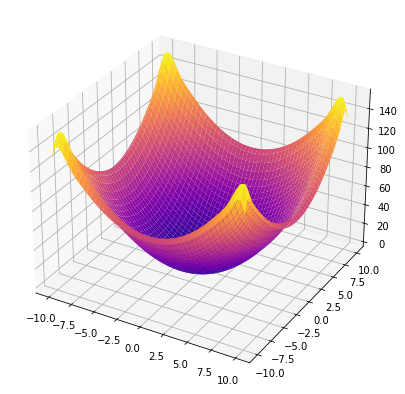

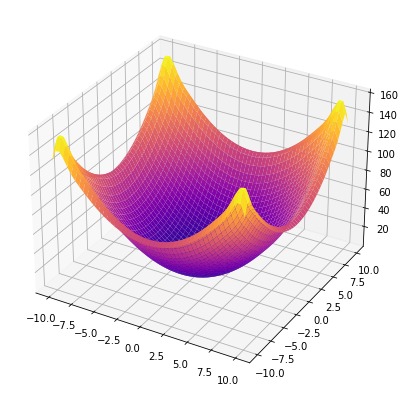

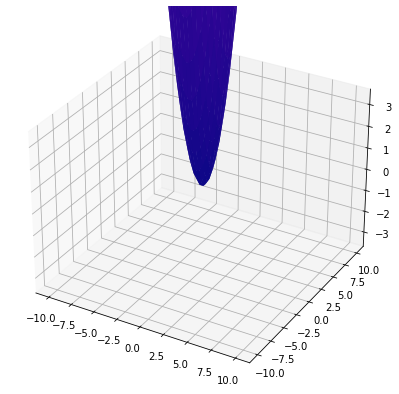

In [7]:
Z1new = mean1.reshape(npredict,npredict)
fig = plt.figure(figsize=(18, 7))
ax = fig.gca(projection='3d')
ax.plot_surface(Xnew, Ynew, Z1new, cmap='plasma')
ax.set_zlim(np.min(Z1new)-2,np.max(Z1new)+2)
plt.show()

Z2new = mean2.reshape(npredict,npredict)
fig = plt.figure(figsize=(18, 7))
ax = fig.gca(projection='3d')
ax.plot_surface(Xnew, Ynew, Z1new, cmap='plasma')
ax.set_zlim(np.min(Z2new)-2,np.max(Z2new)+2)
plt.show()

Z3new = mean3.reshape(npredict,npredict)
fig = plt.figure(figsize=(18, 7))
ax = fig.gca(projection='3d')
ax.plot_surface(Xnew, Ynew, Z1new, cmap='plasma')
ax.set_zlim(np.min(Z3new)-2,np.max(Z3new)+2)
plt.show()


In [8]:

print("\nDistance between GP1 and GP2", distance(gp1, gp2, XYnew))
print("\nDistance between GP1 and GP3", distance(gp1, gp3, XYnew))
print("\nDistance between GP2 and GP3", distance(gp2, gp3, XYnew))

(2500,) (2500,) (2500, 2)

Distance between means,  0.04951595722660276
Correlation between means,  1.0
Distance between cov matrices,  0.0

Distance between GP1 and GP2 0.02228218075197124
(2500,) (2500,) (2500, 2)

Distance between means,  0.6054894040779948
Correlation between means,  0.0
Distance between cov matrices,  0.0

Distance between GP1 and GP3 0.7224702318350977
(2500,) (2500,) (2500, 2)

Distance between means,  0.6054894044686425
Correlation between means,  0.0
Distance between cov matrices,  0.0

Distance between GP2 and GP3 0.7224702320108891


In [305]:
distance(gp1, gp3, XYnew)


Distance between means,  0.6054894040779948
[ 5.86832311e+01 -2.27373675e-17] 2500.0
[ 5.86832311e+01 -2.27373675e-17] 2500.0
Correlation between means,  0
Distance between cov matrices,  0.0


0.7224702318350977